In [111]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import heapq
1.0 - math.pow(0.9, 1/10)


0.010480741793785553

In [291]:
MAX_ITER = 64

eps = 1.19209e-07

def compute_possibility(n, p, x):
    s = 1.0
    for i in range(x):
        s *= (n - i) / (i + 1)
    s *= (p**x) * ((1-p)**(n-x))
    return s

def bs_next_helper(n, c, t, L, m, p):
    s = 0.0
    for i in range(m+1):
        #print(p, L[i], L[i] + t)
        if p < L[i] or p > L[i] + t:
            continue
        #print("s", s, compute_possibility(n, p, m))
        s += compute_possibility(n, p, i)
    if s >= c:
        return True
    return False

#print(bs_next_helper(10, 0.9, 1.0, [0.0,0.0], 0, 0.0001))

def bs_next(n, c, t, L, i, hq):
    if len(hq) == 0:
        return 1.0
    beg = heapq.heappop(hq)
    while len(hq) > 0:
        end = heapq.heappop(hq)
        #print(end, bs_next_helper(n, c, t, L, i, end))
        if bs_next_helper(n, c, t, L, i, end):
            beg = end
            continue
        for _ in range(MAX_ITER):
            mid = (beg + end) / 2.0
            #print("mid:", mid, L[0], t, c, bs_next_helper(n, c, t, L, i+1, mid))
            if bs_next_helper(n, c, t, L, i, mid):
                beg = mid
            else:
                end = mid
        heapq.heappush(hq, beg)
        #heapq.heappush(hq, min(1.0, beg+t))
        heapq.heappush(hq, min(1.0, beg+t+eps))
        heapq.heappush(hq, end)
        return beg
    return 1.0
        

def bci_helper(n, c, t, L):
    for i in range(n+1):
        L[i] = 0.0
    #L[0] = 0.0
    #L[1] = 1.0 - math.pow(c, 1/n)
    hq = []
    for i in range(n+1):
        heapq.heappush(hq, i / n)
    heapq.heappush(hq, t)
    for i in range(n):
        L[i+1] = bs_next(n, c, t, L, i, hq)
        #print(hq)
    
    tmp = test_bci(n, L, t, 0.01)
    #if tmp >= c:
    #    return True
    #return False
    while len(hq) > 0:
        p = heapq.heappop(hq)
        if compute_confidence(n, L, t, p) < c:
            return False
    return True
    #if L[n] + t >= 1.0:
    #    return True
    #return False

def compute_binomail_confidence_interval(n, c):
    L = [0.0 for _ in range(n+1)]
    beg = 0.0
    end = 1.0
    for _ in range(MAX_ITER):
        mid = (beg + end) / 2.0
        ok = bci_helper(n, c, mid, L)
        #print(mid, ok)
        if ok:
            end = mid
        else:
            beg = mid
    bci_helper(n, c, end, L)
    return L, [min(1.0, l + end) for l in L], end

def compute_confidence(n, L, t, p):
    s = 0.0
    for i in range(n+1):
        if L[i] <= p and p <= L[i] + t:
            s += compute_possibility(n, p, i)
    return s
            

def test_bci(n, L, t, step):
    ret = min(compute_confidence(n, L, t, 0.0), compute_confidence(n, L, t, 1.0))
    ind = 0
    p = step
    while p <= 1.0:
        tmp = compute_confidence(n, L, t, p)
        if tmp < ret:
            ret = tmp
            ind = p
        p += step
    return ret, ind

def compute_and_test(n, c, step):
    L, R, t = compute_binomail_confidence_interval(n, c)
    ret, ret_p = test_bci(n, L, t, step)
    print("result:", c, ret, ret_p)
    return L, R, t

#compute_binomail_confidence_interval(10, 0.9)  
#compute_and_test(10, 0.9, 0.01)


result: 0.7 0.7151181128760234 0.18000000000000002
interval: 0.2123281945668582


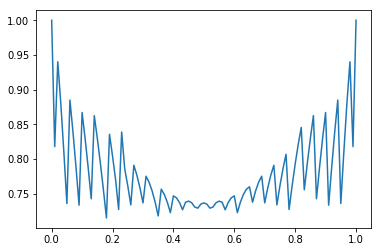

In [296]:
n = 20
c = 0.7
steps = 100
L, R, t = compute_and_test(n, c, (1.0 / steps))
print("interval:", t)
x = [i * (1.0 / steps) for i in range(steps+1)]
y = [compute_confidence(n, L, t, i) for i in x]
#print(x, y)

plt.plot(x,y)
#for i,j in zip(x, y):
#    print(i,j)

In [295]:
print("n:", n, ", confidence:", c, ", interval:", t)
for i, l in enumerate(L):
    print(i, [l,  min(1.0, l + t)], i / n)
#compute_confidence(n, L, t, 0.713201540802663)

n: 20 , confidence: 0.9 , interval: 0.33412755760657614
0 [0.0, 0.33412755760657614] 0.0
1 [0.0052541740694689865, 0.33938173167604513] 0.05
2 [0.02691413261401115, 0.3610416902205873] 0.1
3 [0.05641789624311594, 0.3905454538496921] 0.15
4 [0.09021345530747064, 0.4243410129140468] 0.2
5 [0.1269260599358087, 0.46105361754238483] 0.25
6 [0.16587238278892397, 0.4999999403955001] 0.3
7 [0.20666403328284635, 0.5407915908894225] 0.35
8 [0.24906482137980906, 0.5831923789863852] 0.4
9 [0.2929288851920709, 0.627056442798647] 0.45
10 [0.33801919704609873, 0.6721467546526749] 0.5
11 [0.3811895005158469, 0.7153170581224231] 0.55
12 [0.4243410129140468, 0.7584685705206229] 0.6
13 [0.46105361754238483, 0.795181175148961] 0.65
14 [0.4999999403955001, 0.8341274980020763] 0.7
15 [0.5407915908894225, 0.8749191484959986] 0.75
16 [0.5831923789863852, 0.9173199365929614] 0.8
17 [0.627056442798647, 0.9611840004052232] 0.85
18 [0.6721467546526749, 1.0] 0.9
19 [0.7584685705206229, 1.0] 0.95
20 [0.795181175148